In [1]:
import pandas as pd
from collections import Counter
from bs4 import BeautifulSoup
import re
import numpy as np
from scipy.stats import norm
from scipy.stats import hmean
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
import gensim

import keras 
from keras.models import load_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout
from keras.utils.np_utils import to_categorical
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

from sklearn.metrics import confusion_matrix,accuracy_score,classification_report

import joblib
from wordcloud import WordCloud
from pylab import *
from mlxtend.plotting import plot_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  

pd.set_option('display.max_colwidth', 5000)

Using TensorFlow backend.


In [2]:
df = pd.read_csv('Sentiment140_training_1600000_processed_noemoticon.csv', 
                      encoding = "ISO-8859-1", names=["target", "ids", "date", "flag", "user", "text"], header=None
                     )

In [ ]:
df.head()

In [3]:
df.drop(['ids','date','flag','user'], axis = 1, inplace = True)
df.target = df.target.apply(lambda x: 1 if x == 4 else x)

In [ ]:
df.head()

In [58]:
Counter(df.target)

Counter({0: 800000, 1: 800000})

In [ ]:
df.info()

In [4]:
df['pre_clean_len'] = [len(t) for t in df.text]

In [ ]:
df

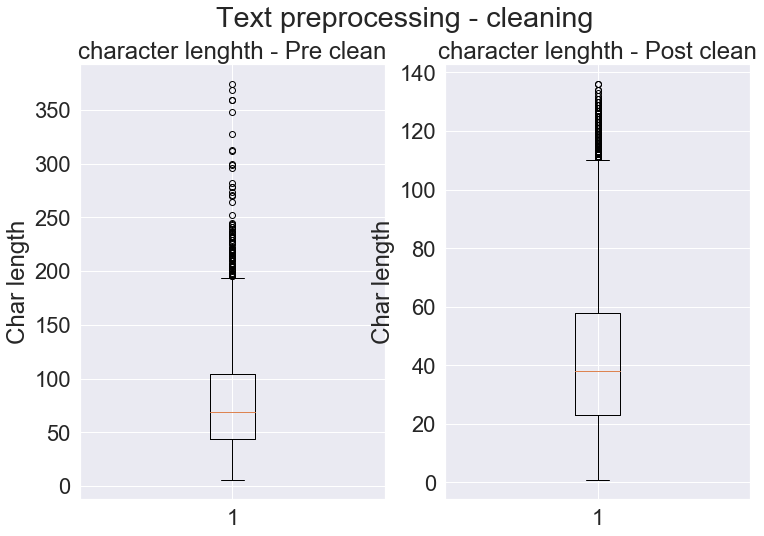

In [443]:
# fig, ax = plt.subplots(figsize=(5, 5))
# df.boxplot(column=['pre_clean_len','post_clean_len'])
# plt.show()

fig, axs = plt.subplots(1,2, figsize=(12, 8))
fig.suptitle('Text preprocessing - cleaning')
axs[0].boxplot(df['pre_clean_len'])
axs[0].set_title('character lenghth - Pre clean')
axs[1].boxplot(df['post_clean_len'])
axs[1].set_title('character lenghth - Post clean')
axs[0].set_ylabel('Char length')
axs[1].set_ylabel('Char length')
plt.show()

In [5]:
contractionMapping = {"ll" : "will", "ain't": "is not", "aren't": "are not","can't": "can not", "can't've": "can not have",
                      "'cause": "because", "could've": "could have", "couldn't": "could not", 
                      "couldn't've": "could not have","didn't": "did not", "doesn't": "does not", "don't": "do not", 
                      "hadn't": "had not", "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not", 
                      "he'd": "he would", "he'd've": "he would have", "he'll": "he will", "he'll've": "he will have", 
                      "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", 
                      "how's": "how is", "I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
                      "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", 
                      "i'd've": "i would have", "i'll": "i will", "i'll've": "i will have","i'm": "i am", 
                      "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", 
                      "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", 
                      "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not",
                      "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", 
                      "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
                      "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", 
                      "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", 
                      "she'd": "she would", "she'd've": "she would have", "she'll": "she will", 
                      "she'll've": "she will have", "she's": "she is", "should've": "should have", 
                      "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have",
                      "so's": "so as", "this's": "this is", "that'd": "that would", "that'd've": "that would have",
                      "that's": "that is", "there'd": "there would", "there'd've": "there would have",
                      "there's": "there is", "here's": "here is", "they'd": "they would", 
                      "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", 
                      "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", 
                      "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", 
                      "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", 
                      "what'll've": "what will have", "what're": "what are", "what's": "what is", 
                      "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did",
                      "where's": "where is", "where've": "where have", "who'll": "who will", 
                      "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", 
                      "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", 
                      "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", 
                      "y'all": "you all", "y'all'd": "you all would", "y'all'd've": "you all would have",
                      "y'all're": "you all are","y'all've": "you all have", "you'd": "you would", 
                      "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", 
                      "you're": "you are", "you've": "you have" }

stopWords = stopwords.words('english')
stopWords.remove('not')

In [6]:
lemmatizer = WordNetLemmatizer()
def cleanText(ip):
    cleanedText = ''
    if len(ip) > 0:
        removeHtml = BeautifulSoup(ip, 'lxml').get_text().lower()
        removeMention = re.sub(r'@[A-Za-z0-9]+','',removeHtml).strip().rstrip('.')
        removeUrl1 = re.sub('https?://[A-Za-z0-9./]+', '', removeMention)
        removeUrl2 = re.sub('[A-Za-z0-9./]+(com|net|org)', '', removeUrl1)
        #removeBOM = removeUrl.encode("ISO-8859-1").decode('utf-8-sig').replace(u"\ufffd", "?")
        #removeSpecialChar = re.sub("[^a-zA-Z']", " ", removeBOM).lower()
        removeSpecialChar = re.sub("[^a-zA-Z']", " ", removeUrl2)
        removeContraction = ' '.join([contractionMapping[t] 
                                      if t in contractionMapping else t for t in removeSpecialChar.split(" ")])
        removeDoubleDotSpace = re.sub("[ ]+|'",' ',re.sub('[.]+','.', removeContraction))
        removeStopWords = ' '.join([ x for x in word_tokenize(removeDoubleDotSpace) if x not in stopWords ]) 
        extractNoun = lemmatizer.lemmatize(removeStopWords)
        cleanedText = extractNoun.strip()
    return cleanedText

In [50]:
stopWords = stopwords.words('english')

In [ ]:
df.text[226]

In [ ]:
df.text[226].encode("ISO-8859-1").decode('utf-8-sig').replace(u"\ufffd", "?")

In [62]:
cleanText('#apples apple')

'apples apple'

In [ ]:
df['text'].head()

In [7]:
df['cleanedText'] = df['text'].apply(cleanText)
df['post_clean_len'] = [len(t) for t in df.cleanedText]
df = df[df.cleanedText != '' ]
df.reset_index(inplace=True, drop=True)
df

C:\Users\RajapandianMariappan\Anaconda3\lib\site-packages\bs4\__init__.py:294: UserWarning: "b' i just received my G8 viola exam.. and its... well... .. disappointing.. :\\..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Users\RajapandianMariappan\Anaconda3\lib\site-packages\bs4\__init__.py:294: UserWarning: "b'E3 ON PLAYSTATION HOME IN ABOUT AN HOUR!!!!!!!!!! \\../  \\../'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


,target,text,pre_clean_len,cleanedText,post_clean_len
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D",115,awww bummer shoulda got david carr third day,44
1,0,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!,111,upset not update facebook texting might cry result school today also blah,73
2,0,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds,89,dived many times ball managed save rest go bounds,49
3,0,my whole body feels itchy and like its on fire,47,whole body feels itchy like fire,32
4,0,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.",111,not behaving mad not see,24
...,...,...,...,...,...
1592970,1,Just woke up. Having no school is the best feeling ever,56,woke school best feeling ever,29
1592971,1,TheWDB.com - Very cool to hear old Walt interviews! â« http://blip.fm/~8bmta,78,cool hear old walt interviews bmta,34
1592972,1,Are you ready for your MoJo Makeover? Ask me for details,57,ready mojo makeover ask details,31
1592973,1,Happy 38th Birthday to my boo of alll time!!! Tupac Amaru Shakur,65,happy th birthday boo alll time tupac amaru shakur,50


In [8]:
def plotWordCloud(data, label, color = "white"):
    stringCollection = pd.Series(data).str.cat(sep=' ')
    wordcloud = WordCloud(background_color=color, width=1600, height=800,max_font_size=200).generate(stringCollection)
    fig = plt.figure(figsize=(12,10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    fig.suptitle('\n'+label, fontsize=20)
    fig.subplots_adjust(top=2.3)
    plt.show()


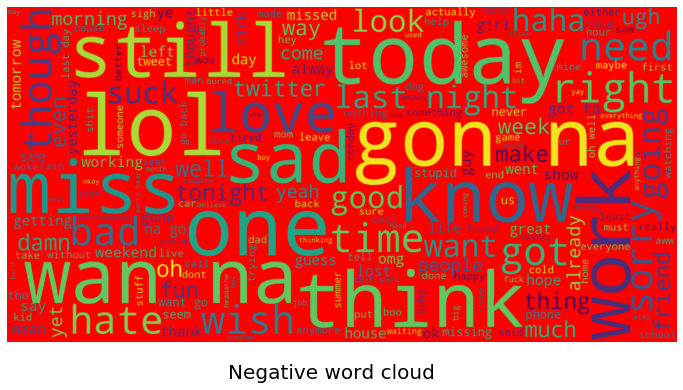

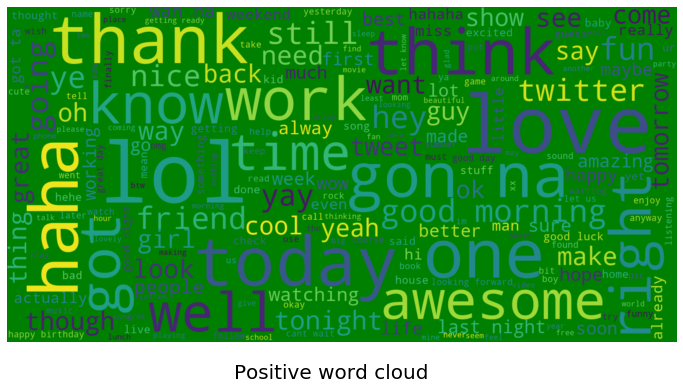

In [9]:
plotWordCloud(df[df.target == 0].cleanedText.to_list(), 'Negative word cloud', "red")
plotWordCloud(df[df.target == 1].cleanedText.to_list(), 'Positive word cloud', "green")

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df.cleanedText, df.target, test_size=0.3, random_state=5000)
print("TRAIN size:", len(X_train))
print("TEST size:", len(X_test))

TRAIN size: 1115082
TEST size: 477893


In [65]:
print("TRAIN size:", str(Counter(y_train)))
print("TEST size:", str(Counter(y_test)))

TRAIN size: Counter({0: 557667, 1: 557415})
TEST size: Counter({0: 239131, 1: 238762})


In [66]:
# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 100
W2V_MIN_COUNT = 10

documents = [txt.split() for txt in X_train] 
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=16)
w2v_model.build_vocab(documents)

In [67]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 27423


In [74]:
#w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)
len(documents)

1114651

In [85]:
w2v_model.most_similar("sad")

C:\Users\RajapandianMariappan\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('lowlands', 0.22730472683906555),
 ('bunk', 0.207004576921463),
 ('procedure', 0.20597156882286072),
 ('fails', 0.2051391899585724),
 ('ringer', 0.20415142178535461),
 ('sonata', 0.2034100890159607),
 ('aikido', 0.2013828158378601),
 ('arggg', 0.20110519230365753),
 ('betrayed', 0.19913825392723083),
 ('fbook', 0.19540560245513916)]

In [75]:
w2v_model.most_similar("sad")

C:\Users\RajapandianMariappan\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('wudnt', 0.379879891872406),
 ('guud', 0.36496037244796753),
 ('stephs', 0.350702702999115),
 ('frum', 0.34896665811538696),
 ('maverick', 0.3439401090145111),
 ('eeepc', 0.3425982892513275),
 ('lowlands', 0.34049591422080994),
 ('bagged', 0.3390476703643799),
 ('kyra', 0.336050420999527),
 ('task', 0.3326137065887451)]

In [39]:
w2v_model.most_similar("sad")

C:\Users\RajapandianMariappan\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('lowlands', 0.22730472683906555),
 ('bunk', 0.207004576921463),
 ('procedure', 0.20597156882286072),
 ('fails', 0.2051391899585724),
 ('ringer', 0.20415142178535461),
 ('sonata', 0.2034100890159607),
 ('aikido', 0.2013828158378601),
 ('arggg', 0.20110519230365753),
 ('betrayed', 0.19913825392723083),
 ('fbook', 0.19540560245513916)]

In [68]:
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 300
# This is fixed.
EMBEDDING_DIM = 300

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
vocab_size = len(word_index)
print('Found %s unique tokens.' % len(word_index))

# Convert the data to padded sequences
X_train_padded = tokenizer.texts_to_sequences(X_train)
X_train_padded = pad_sequences(X_train_padded, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_train_padded.shape)

Found 217170 unique tokens.
Shape of data tensor: (1115082, 300)


In [69]:
# Embedding matrix for the embedding layer
embedding_matrix = np.zeros((vocab_size+1, W2V_SIZE))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(217171, 300)


In [70]:
# Build Model


model = Sequential()
model.add(Embedding(vocab_size+1, W2V_SIZE, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
model.add(Dropout(0.3))
model.add(Conv1D(300,3,activation='relu'))
# we use max pooling:
model.add(GlobalMaxPooling1D())
model.add(Dense(200, activation='sigmoid'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          65151300  
_________________________________________________________________
dropout_1 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 298, 300)          270300    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               60200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [86]:
# Training 

callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

BATCH_SIZE = 32
EPOCH_SIZE = 5
VALIDATION_SPLIT_SIZE = 0.1

history = model.fit(X_train_padded, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCH_SIZE,
                    validation_split=VALIDATION_SPLIT_SIZE,
                    verbose=1,
                    callbacks=callbacks)



Train on 1003185 samples, validate on 111466 samples
Epoch 1/5
1003185/1003185 [==============================] - 5507s 5ms/step - loss: 0.5527 - accuracy: 0.7112 - val_loss: 0.5213 - val_accuracy: 0.7360
Epoch 2/5
1003185/1003185 [==============================] - 5559s 6ms/step - loss: 0.5345 - accuracy: 0.7265 - val_loss: 0.5217 - val_accuracy: 0.7377
Epoch 3/5
1003185/1003185 [==============================] - 5939s 6ms/step - loss: 0.5233 - accuracy: 0.7344 - val_loss: 0.5357 - val_accuracy: 0.7266
Epoch 4/5
1003185/1003185 [==============================] - 5547s 6ms/step - loss: 0.5150 - accuracy: 0.7415 - val_loss: 0.4972 - val_accuracy: 0.7536
Epoch 5/5
1003185/1003185 [==============================] - 5910s 6ms/step - loss: 0.5086 - accuracy: 0.7459 - val_loss: 0.5014 - val_accuracy: 0.7530


In [71]:
# Training 

callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

BATCH_SIZE = 32
EPOCH_SIZE = 5
VALIDATION_SPLIT_SIZE = 0.1

history = model.fit(X_train_padded, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCH_SIZE,
                    validation_split=VALIDATION_SPLIT_SIZE,
                    verbose=1,
                    callbacks=callbacks)



Train on 1003573 samples, validate on 111509 samples
Epoch 1/5
1003573/1003573 [==============================] - 6885s 7ms/step - loss: 0.5748 - accuracy: 0.6918 - val_loss: 0.5327 - val_accuracy: 0.7272


C:\Users\RajapandianMariappan\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


Epoch 2/5
1003573/1003573 [==============================] - 7690s 8ms/step - loss: 0.5276 - accuracy: 0.7331 - val_loss: 0.4950 - val_accuracy: 0.7574
Epoch 3/5
1003573/1003573 [==============================] - 33195s 33ms/step - loss: 0.5106 - accuracy: 0.7460 - val_loss: 0.5121 - val_accuracy: 0.7471
Epoch 4/5
1003573/1003573 [==============================] - 5228s 5ms/step - loss: 0.4998 - accuracy: 0.7538 - val_loss: 0.4803 - val_accuracy: 0.7680
Epoch 5/5
1003573/1003573 [==============================] - 4607s 5ms/step - loss: 0.4927 - accuracy: 0.7589 - val_loss: 0.4882 - val_accuracy: 0.7628


ACCURACY: 0.7528218030929565
LOSS: 0.5035901173092182


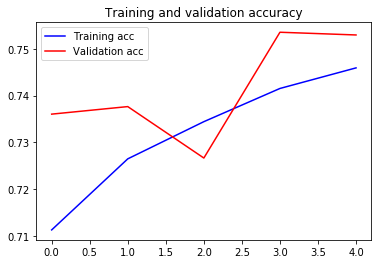

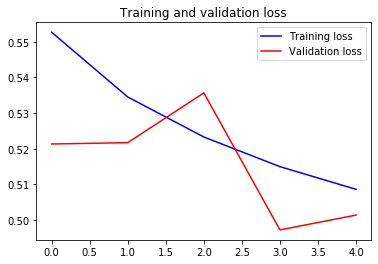

In [91]:
X_test_padded = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_padded, maxlen=MAX_SEQUENCE_LENGTH)
score = model.evaluate(X_test_padded, y_test, batch_size=512)

print("ACCURACY:",score[1])
print("LOSS:",score[0])

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

477893/477893 [==============================] - 569s 1ms/step
ACCURACY: 0.761235237121582
LOSS: 0.49088620293331314


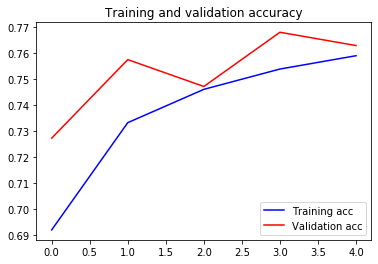

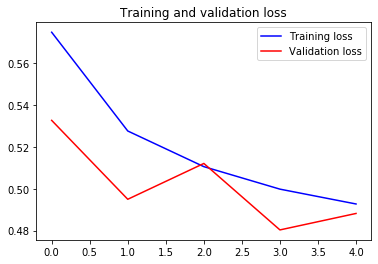

In [72]:
X_test_padded = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_padded, maxlen=MAX_SEQUENCE_LENGTH)
score = model.evaluate(X_test_padded, y_test, batch_size=512)

print("ACCURACY:",score[1])
print("LOSS:",score[0])

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [90]:
history.history

{'val_loss': [0.5213288105277644,
  0.5217055504627235,
  0.5356534810676719,
  0.49724351981073206,
  0.5013998505011822],
 'val_accuracy': [0.7360361218452454,
  0.7376509308815002,
  0.72663414478302,
  0.7535750865936279,
  0.7529919147491455],
 'loss': [0.5526542835931778,
  0.5345024046551045,
  0.5232909138901974,
  0.5149817453001672,
  0.5086217998287236],
 'accuracy': [0.7112377, 0.72645825, 0.73442286, 0.74153423, 0.74594116],
 'lr': [0.001, 0.001, 0.001, 0.001, 0.001]}

In [92]:
model.save('sentiment_analysis_model_new.h5')

In [114]:
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report

In [75]:
def predict(text, include_neutral=True, MAX_SEQUENCE_LENGTH=300):
    sentiment = ''
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=MAX_SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    if score<0.35:
        sentiment = "Negative"
    elif score>0.35 and score<0.7:
        sentiment = "Neutral"
    else:
        sentiment = "Positive"
    #print(score)
    return { "text": text, "prediction" : {"score": float(score), "sentiment" : sentiment } }  


In [3]:
model = load_model('sentiment_analysis_model_new.h5')

In [204]:
pad_sequences(tokenizer.texts_to_sequences(['text']), maxlen=MAX_SEQUENCE_LENGTH)

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0

In [35]:
centerVal = df[df.target==0].target.count()-1
no_of_val_to_process = 125000
start = centerVal-no_of_val_to_process
end  = centerVal+no_of_val_to_process

X_train1, X_test1, y_train1, y_test1 = train_test_split(df.cleanedText.iloc[start:end], df.target.iloc[start:end], test_size=0.3, random_state=5000)
print("TRAIN size:", len(X_train1))
print("TEST size:", len(X_test1))

MAX_SEQUENCE_LENGTH1 = 300
# This is fixed.
EMBEDDING_DIM = 300

tokenizer1 = Tokenizer()
tokenizer1.fit_on_texts(X_train1)
word_index1 = tokenizer1.word_index
vocab_size1 = len(word_index1)
print('Found %s unique tokens.' % len(word_index1))

# Convert the data to padded sequences
X_train_padded1 = tokenizer1.texts_to_sequences(X_train1)
X_train_padded1 = pad_sequences(X_train_padded1, maxlen=MAX_SEQUENCE_LENGTH1)
print('Shape of X train data tensor:', X_train_padded1.shape)

X_test_padded1 = tokenizer1.texts_to_sequences(X_test1)
X_test_padded1 = pad_sequences(X_test_padded1, maxlen=MAX_SEQUENCE_LENGTH1)
print('Shape of X test data tensor:',X_test_padded1.shape)


W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 100
W2V_MIN_COUNT = 10

documents1 = [txt.split() for txt in X_train1] 
w2v_model1 = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=16)
w2v_model1.build_vocab(documents1)

embedding_matrix1 = np.zeros((vocab_size1+1, W2V_SIZE))
for word, i in tokenizer1.word_index.items():
    if word in w2v_model1.wv:
        embedding_matrix1[i] = w2v_model1.wv[word]
print(embedding_matrix1.shape)

print(X_train_padded1.shape)
print(y_train1.shape)
print(embedding_matrix1.shape)


embedding_layer1 = Embedding(vocab_size1+1, W2V_SIZE, weights=[embedding_matrix1], input_length=MAX_SEQUENCE_LENGTH1, trainable=False)
#embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=300, trainable=False)
model1 = Sequential()
model1.add(embedding_layer1)
model1.add(Dropout(0.1))
model1.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model1.add(Dropout(0.1))
model1.add(Dense(1, activation='sigmoid'))
model1.summary()
model1.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

TRAIN size: 175000
TEST size: 75000
Found 71654 unique tokens.
Shape of X train data tensor: (175000, 300)
Shape of X test data tensor: (75000, 300)
(71655, 300)
(175000, 300)
(175000,)
(71655, 300)
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 300, 300)          21496500  
_________________________________________________________________
dropout_7 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dropout_8 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 21,657,001
Trainable params: 160,501
No

In [36]:
model1_history=model1.fit(X_train_padded1, y_train1,batch_size=512,epochs=5,validation_split=0.3,verbose=1)

Train on 122499 samples, validate on 52501 samples
Epoch 1/5
122499/122499 [==============================] - 13168s 107ms/step - loss: 0.6911 - accuracy: 0.5266 - val_loss: 0.6842 - val_accuracy: 0.5641
Epoch 2/5
122499/122499 [==============================] - 41760s 341ms/step - loss: 0.6824 - accuracy: 0.5918 - val_loss: 0.6762 - val_accuracy: 0.6095
Epoch 3/5
122499/122499 [==============================] - 3107s 25ms/step - loss: 0.6637 - accuracy: 0.6167 - val_loss: 0.6491 - val_accuracy: 0.6399
Epoch 4/5
122499/122499 [==============================] - 14164s 116ms/step - loss: 0.6464 - accuracy: 0.6312 - val_loss: 0.6350 - val_accuracy: 0.6497
Epoch 5/5
122499/122499 [==============================] - 10247s 84ms/step - loss: 0.6374 - accuracy: 0.6387 - val_loss: 0.6277 - val_accuracy: 0.6490


75000/75000 [==============================] - 815s 11ms/step
ACCURACY: 0.651146650314331
LOSS: 0.6272322557004293


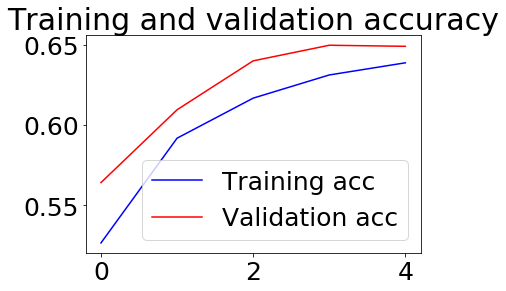

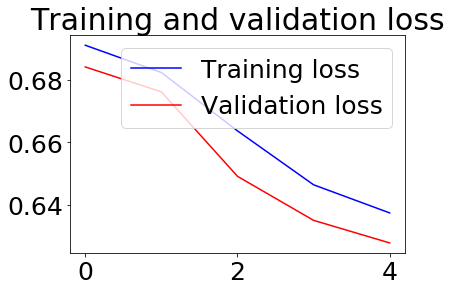

In [40]:
X_test_padded1 = tokenizer1.texts_to_sequences(X_test1)
X_test_padded1 = pad_sequences(X_test_padded1, maxlen=300)
score1 = model1.evaluate(X_test_padded1, y_test1, batch_size=512)

print("ACCURACY:",score1[1])
print("LOSS:",score1[0])

acc = model1_history.history['accuracy']
val_acc = model1_history.history['val_accuracy']
loss = model1_history.history['loss']
val_loss = model1_history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [62]:
len(scores)

477893

In [67]:
X_test_padded1 = tokenizer1.texts_to_sequences(X_test1)
X_test_padded1 = pad_sequences(X_test_padded1, maxlen=300)
score1 = model1.predict(X_test_padded1, verbose=1, batch_size=1024)

75000/75000 [==============================] - 617s 8ms/step


In [68]:
y_pred1=np.where(score1 > 0.5,1,0)
cm1=confusion_matrix(y_test1,y_pred1, [1,0])
print(cm1)

[[27769  9739]
 [16425 21067]]


In [70]:
print(classification_report(y_test1, y_pred1))

              precision    recall  f1-score   support

           0       0.68      0.56      0.62     37492
           1       0.63      0.74      0.68     37508

    accuracy                           0.65     75000
   macro avg       0.66      0.65      0.65     75000
weighted avg       0.66      0.65      0.65     75000



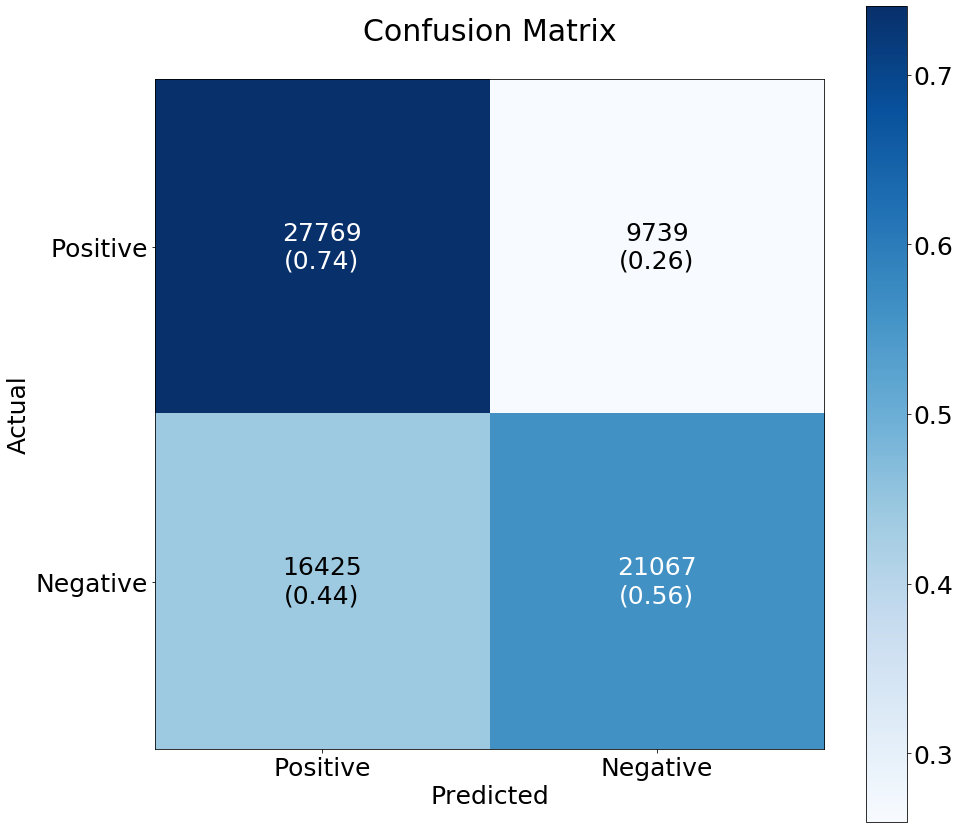

array([21067, 16425,  9739, 27769], dtype=int64)

In [69]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 25})
label = ['Positive', 'Negative']
fig, ax = plot_confusion_matrix(conf_mat=cm1,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                                figsize=(15, 15)
                               #, class_names = [1,0]
                               )
ax.set_title('Confusion Matrix')
ax.set_xticklabels([''] + label)
ax.set_yticklabels([''] + label)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()

#tn, fp, fn, tp = confusion_matrix(y_test_m,y_pred_m).ravel()
confusion_matrix(y_test1,y_pred1).ravel()

In [38]:
def Model1_predict(text, include_neutral=True, MAX_SEQUENCE_LENGTH=300):
    sentiment = ''
    # Tokenize text
    x_test = pad_sequences(tokenizer1.texts_to_sequences([text]), maxlen=MAX_SEQUENCE_LENGTH)
    # Predict
    score = model1.predict([x_test])[0]
    if score<0.35:
        sentiment = "Negative"
    elif score>0.35 and score<0.7:
        sentiment = "Neutral"
    else:
        sentiment = "Positive"
    #print(score)
    return { "text": text, "prediction" : {"score": float(score), "sentiment" : sentiment } }  



{'text': 'angry',
 'prediction': {'score': 0.5323675870895386, 'sentiment': 'Neutral'}}

In [78]:
predict("happy")

{'text': 'happy',
 'prediction': {'score': 0.9298253059387207, 'sentiment': 'Positive'}}

In [211]:
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report

In [15]:
X_test_padded = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_padded, maxlen=300)
scores = model.predict(X_test_padded, verbose=1, batch_size=1024)

477893/477893 [==============================] - 30613s 64ms/step


In [213]:
scores

array([[0.7656952 ],
       [0.55200636],
       [0.67425555],
       ...,
       [0.9485787 ],
       [0.42679995],
       [0.98004866]], dtype=float32)

In [16]:
y_pred=np.where(scores>0.5,1,0)

In [215]:
y_pred

array([[1],
       [1],
       [1],
       ...,
       [1],
       [0],
       [1]])

In [216]:
y_test

89193      0
150155     0
558673     0
857260     1
720600     0
          ..
473527     0
760583     0
1096572    1
1239093    1
1252219    1
Name: target, Length: 477708, dtype: int64

In [17]:
cm=confusion_matrix(y_test,y_pred, [1,0])
print(cm)

[[200450  38312]
 [ 77398 161733]]


In [218]:
print(accuracy_score(y_pred,y_test))

0.7528218074639738


In [18]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.68      0.74    239131
           1       0.72      0.84      0.78    238762

    accuracy                           0.76    477893
   macro avg       0.76      0.76      0.76    477893
weighted avg       0.76      0.76      0.76    477893



In [73]:
joblib.dump(w2v_model,'word2vec_v2.pkl')
joblib.dump(tokenizer,'tokenizer_X_train_v2.pkl')
joblib.dump(tokenizer1,'tokenizer_X_test_v2.pkl')
joblib.dump(model,'final_model_cnn_v2.pkl')

['final_model_cnn_v2.pkl']

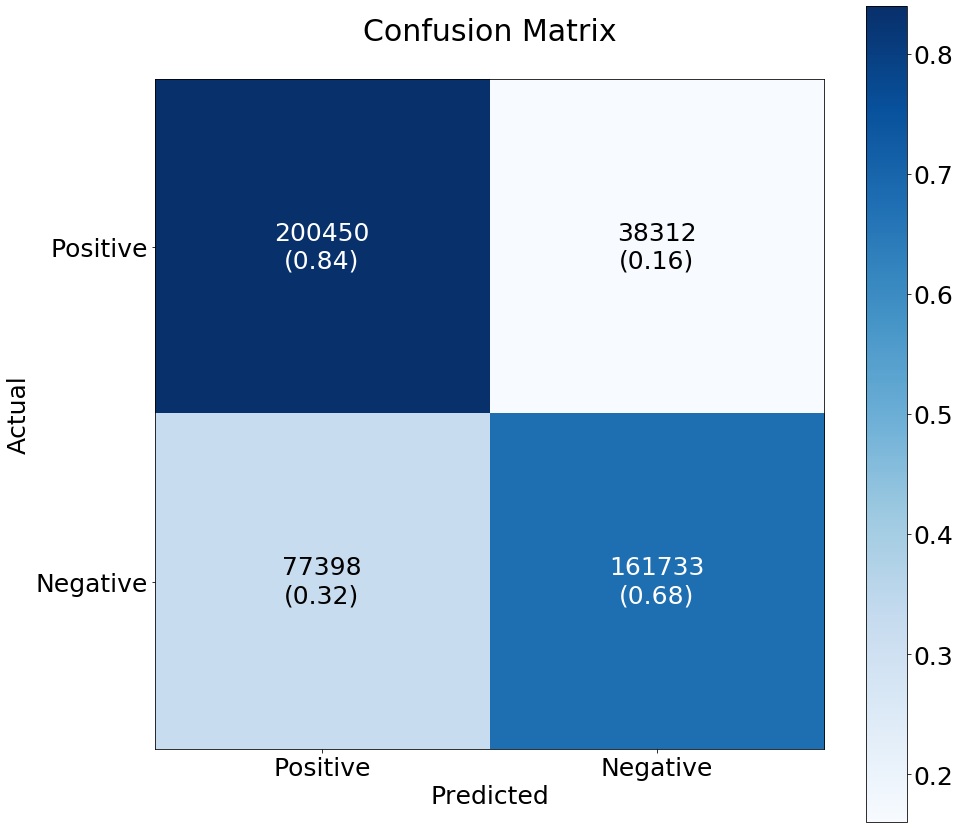

array([161733,  77398,  38312, 200450], dtype=int64)

In [24]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 25})
label = ['Positive', 'Negative']
fig, ax = plot_confusion_matrix(conf_mat=cm,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                                figsize=(15, 15)
                               #, class_names = [1,0]
                               )
ax.set_title('Confusion Matrix')
ax.set_xticklabels([''] + label)
ax.set_yticklabels([''] + label)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()

#tn, fp, fn, tp = confusion_matrix(y_test_m,y_pred_m).ravel()
confusion_matrix(y_test,y_pred).ravel()

In [21]:
dir(ax)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_text',
 '_adjustable',
 '_agg_filter',
 '_alpha',
 '_anchor',
 '_animated',
 '_aspect',
 '_autoscaleXon',
 '_autoscaleYon',
 '_autotitlepos',
 '_axes',
 '_axes_class',
 '_axes_locator',
 '_axisbelow',
 '_clipon',
 '_clippath',
 '_connected',
 '_contains',
 '_convert_dx',
 '_current_image',
 '_facecolor',
 '_frameon',
 '_gci',
 '_gen_axes_patch',
 '_gen_axes_spines',
 '_get_axis_list',
 '_get_clipping_extent_bbox',
 '_get_lines',
 '_get_patches_for_fill',
 '_get_view',
 '_gid',
 '_gridOn',
 '_in_layout',
 '_init_axis',
 '_label',
 '_layoutbox',
 '_left_title',
 '_make_twin_axes',
 '_

In [452]:
predict('mad')

[0.2]


{'score': 0.20280151069164276, 'sentiment': 'Negative'}

In [12]:
w2v_model = joblib.load('word2vec.pkl')
tokenizer = joblib.load('tokenizer_X_train.pkl')
tokenizer1 = joblib.load('tokenizer_y_train.pkl')
model = joblib.load('final_model_cnn.pkl')

In [6]:
myList = ['Good', 'Bad', 'Sad', 'Mad', 'He is good', 'He is bad', 
          'I am ok', 'Where are you going', 'I am fine',
         'I do not like this', 'I want this', 'NExt month Trump will come to India', 
          "China's ecomoney is not good"]

In [48]:
predict("ji")

{'text': 'ji',
 'prediction': {'score': 0.5553499460220337, 'sentiment': 'Neutral'}}

In [74]:
[ predict(x) for x in myList ]

[{'text': 'Good',
  'prediction': {'score': 0.9736762046813965, 'sentiment': 'Positive'}},
 {'text': 'Bad',
  'prediction': {'score': 0.10720106959342957, 'sentiment': 'Negative'}},
 {'text': 'Sad',
  'prediction': {'score': 0.0054823593236505985, 'sentiment': 'Negative'}},
 {'text': 'Mad',
  'prediction': {'score': 0.2207874208688736, 'sentiment': 'Negative'}},
 {'text': 'He is good',
  'prediction': {'score': 0.9736762046813965, 'sentiment': 'Positive'}},
 {'text': 'He is bad',
  'prediction': {'score': 0.10720106959342957, 'sentiment': 'Negative'}},
 {'text': 'I am ok',
  'prediction': {'score': 0.6808728575706482, 'sentiment': 'Neutral'}},
 {'text': 'Where are you going',
  'prediction': {'score': 0.6838974952697754, 'sentiment': 'Neutral'}},
 {'text': 'I am fine',
  'prediction': {'score': 0.9155787229537964, 'sentiment': 'Positive'}},
 {'text': 'I do not like this',
  'prediction': {'score': 0.1493898630142212, 'sentiment': 'Negative'}},
 {'text': 'I want this',
  'prediction': {